# Overview

## Time series analysis

In [2]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

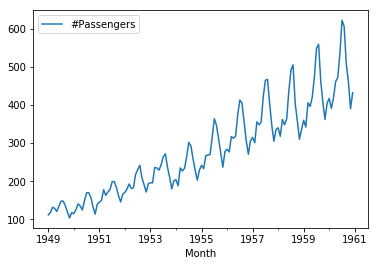

In [7]:
pass_df = pd.read_csv('../datasets/air-passengers.csv')
pass_df['Month'] = pd.to_datetime(pass_df['Month'])
pass_df = pass_df.set_index('Month')
pass_df.plot()

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(pass_df)
trend, seasonal, residual = decomp.trend, decomp.seasonal, decomp.resid

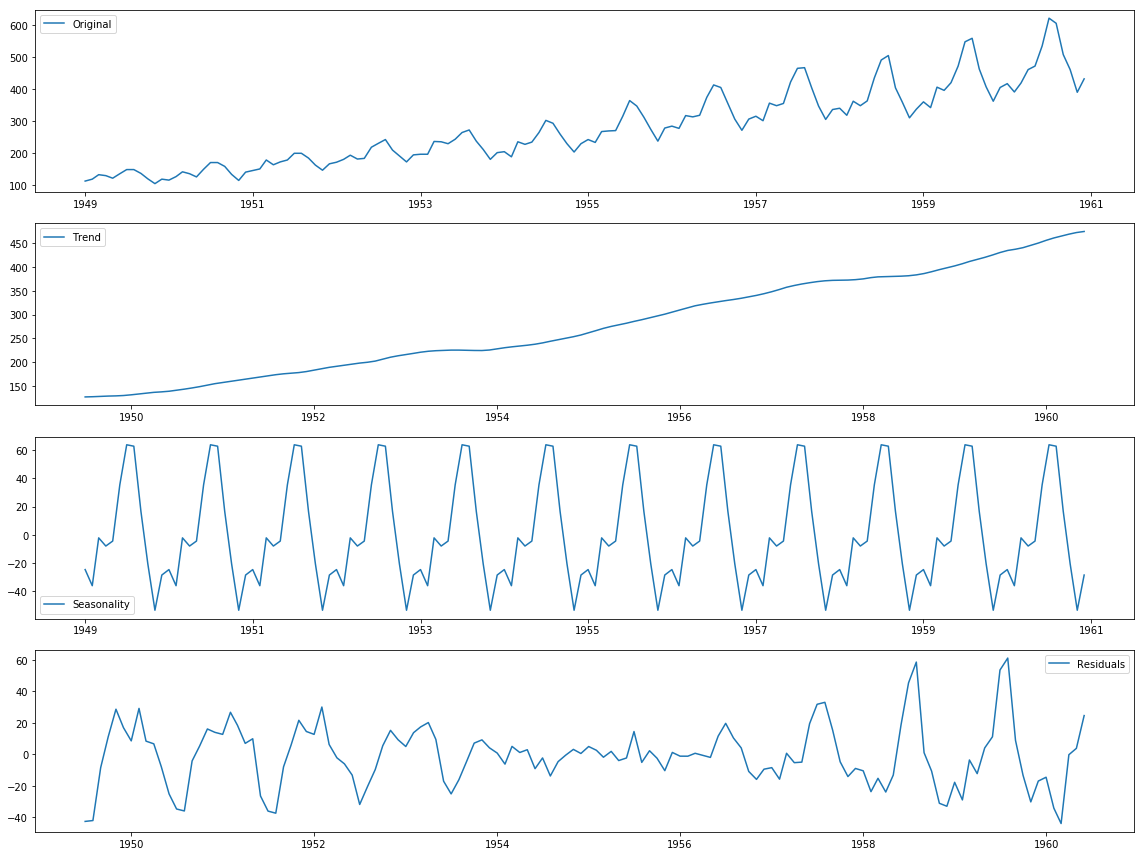

In [17]:
fig, ax = plt.subplots(4, 1, figsize=(16, 12))
ax[0].plot(pass_df, label = 'Original')
ax[0].legend(loc = 'best')
ax[1].plot(trend, label = 'Trend')
ax[1].legend(loc = 'best')
ax[2].plot(seasonal, label = 'Seasonality')
ax[2].legend(loc = 'best')
ax[3].plot(residual, label = 'Residuals')
ax[3].legend(loc = 'best')
fig.tight_layout()

## Model and transform

### Test for stationary

In [24]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, lags, crit = kpss(list(pass_df['#Passengers']))
f'Our data is not stationary since p is {p_value}'

C:\Users\chuan\Anaconda3\envs\keras\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


'Our data is not stationary since p is 0.01'

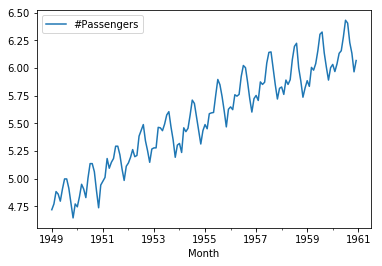

In [27]:
ts_log = np.log(pass_df)
ts_log.plot()

In [34]:
_, p_value, _, _ = kpss(list(ts_log['#Passengers'].diff().dropna()))
f'Our difference in value is stationary because p is {p_value}'

C:\Users\chuan\Anaconda3\envs\keras\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


'Our difference in value is stationary because p is 0.1'

# ARIMA Model

In [45]:
from pmdarima import auto_arima

model = auto_arima(ts_log, m=12, seasonal=True, D=1)
model.fit(ts_log)
model.summary()

C:\Users\chuan\Anaconda3\envs\keras\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\chuan\Anaconda3\envs\keras\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\chuan\Anaconda3\envs\keras\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\chuan\Anaconda3\envs\keras\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\chuan\Anaconda3\envs\keras\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood opti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 249.593
Date:                            Sun, 10 Mar 2019   AIC                           -489.187
Time:                                    22:06:05   BIC                           -474.773
Sample:                                         0   HQIC                          -483.330
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0116      0.007      1.694      0.090      -0.002       0.025
ar.L1          0.9016      0.056     16.077      0.000       0.792       1.012
ma.L1         -0.3354      0.102     -3.274      0.001      -0.536      -0.135
ma.S.L12      -0.5560      0.106     -5.252      0.000      -0.764      -0.349
sigma2         0.0013      0.000      9.225      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       39.97   Jarque-Bera (JB):                 7.16
Prob(Q):                              0.47   Prob(JB):                         0.03
Heteroskedasticity (H):               0.58   Skew:                             0.05
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

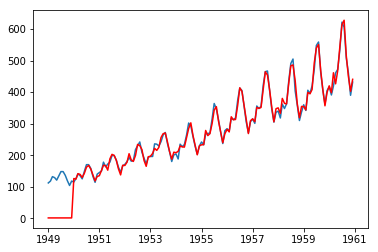

In [47]:
results = model.predict_in_sample()
results = pd.DataFrame(results)

results['Month'] = pass_df.index
results.set_index('Month', inplace = True)

plt.plot(pass_df)
plt.plot(np.exp(results), color = 'red')

In [53]:
# Making prediction
periods_to_forecast = 40
forecast = model.predict(n_periods = periods_to_forecast)

In [54]:
# Create a range of future dates that is the length of the periods you've chosen to forecast
range = pd.date_range(pass_df.index[-1], periods = periods_to_forecast,
              freq='MS').strftime("%Y-%m-%d").tolist()

# Turn that range into a dataframe that includes your predictions
future_months = pd.DataFrame(range, columns = ['Month'])
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)

In [55]:
future_months['Prediction'] = np.exp(forecast)

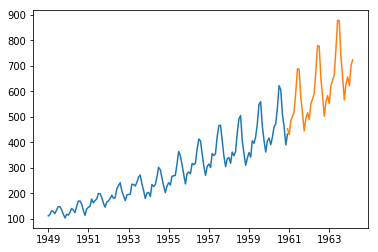

In [58]:
plt.plot(pass_df)
plt.plot(future_months)
plt.show()